# Importing all libraries used during this assignment

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import warnings
from countrygroups import EUROPEAN_UNION
from countryinfo import CountryInfo
import glob
import requests
from functools import partial, reduce 
import missingno as msno


#managing warnings(ignoring them mostly)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)     
warnings.filterwarnings('ignore')

#setting display options
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (25, 14)
plt.style.use('seaborn-whitegrid')

from matplotlib.pyplot import cm
color = 'tab20c'

# Introduction to The Project

The brief of this project states that we must focus on the comparison of one irish agricultural sector to similar sectors worldwide. To begin with we will simply start by using data from FAOSTAT to compare the production of dairy products in ireland and other EU countries, after which we will extend our analysis to other countries around the world, such as USA or NZ. A handful of machine learning techniques will be used to make predictions regarding the milk production in these countries, most likely in the units of L/Hectare or L/cow. Throughout this project we will include sentiment analysts so that we may determine if changes in public sentiment reflect the currrent market conditions.

# Importing the Datasets, and building a dataset that we can use for our EDA, statistics, and machine learning

In [24]:
# importing the land data
land_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\FAOSTAT_Land_Use.csv', on_bad_lines='skip')

# importing dairy products data
dairy_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\FAOSTAT_DAIRY_DATA.csv', on_bad_lines='skip')

#importing producer price data
price_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Producer_milk_prices.csv', on_bad_lines='skip')

#importing export data
export_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\import_export_prices_v1.csv', on_bad_lines='skip')

#importing manure data
manure_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Manure_on_pasture.csv', on_bad_lines='skip')

#importing fertilizer data
fertilizer_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Fert_nutrient_agri.csv', on_bad_lines='skip')


#to deal with all of the temp and rain files we will create custom functions that put the year/country, and annual value in 
# a dataframe and then appends it to a list of dataframes. We will then concatenate all of the dataframes in the list into one
# dataframe

#function to process the csv files and get them in the formast we want in the final dataframe
def process(file, col_name):
    df = pd.read_csv(file, on_bad_lines='skip', skiprows=1)
        
    #change NaN column name
    df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
    #add acolumn that contains country code in each cell
    df['key'] = df.columns[1] + df['Year'].astype(str)
    df.rename(columns={df.columns[1]: col_name}, inplace=True)
    df = df.filter(['key', col_name] )
    return df

#function to create a dataframe from all of the csv files in a folder, and apply the pre processing steps 
#detailed in the process function
def files_to_df(path, col_name):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (process(filename, col_name) for filename in csv_files)
    df = pd.concat(df_list, ignore_index=True)
    return df

#creating a dataframe for the rain data
rain_df = files_to_df(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Eu_rain_data', 'Rainfall_mm/yr')
 
#creating a dataframe for the temp data
temp_df = files_to_df(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Eu_temp_data', 'Temperature_C')


### 1) To kick this project off, we will focus on taking these datasets that we have imported above, and condense them down to a single dataset. We could certainly get away without going through these steps, but doing this now should save us a few headaches somewhere down the line.

a) We are using the dairy products dataset as our jumping off point. This contains data related to many different products, but we will be mostly concerned with information related to Raw milk. We will isolate data related to this and use it as a base for the rest of our datasets

In [25]:

# look at the structure of the dairy data
dairy_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1961,1961,tonnes,7000.0,I,Imputed value
1,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1962,1962,tonnes,7000.0,I,Imputed value
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1963,1963,tonnes,8000.0,I,Imputed value
3,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1964,1964,tonnes,8000.0,I,Imputed value
4,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1965,1965,tonnes,9000.0,I,Imputed value


Okay, it looks like there are some years where the values for dairy products were not recorded. We will first look at the years present & the items for which data is available.

In [26]:
#find unique of dairy items in the dataset, and filter only the ones we want to see
print(dairy_df['Item'].unique())
items = ['Raw milk of cattle']

['Butter of cow milk' 'Cattle' 'Raw milk of cattle' 'Skim milk of cows'
 'Cheese from whole cow milk' 'Cheese from skimmed cow milk'
 'Skim milk and whey powder' 'Buttermilk, dry']


In [27]:
# what are the unique year values?
dairy_df['Year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=int64)

In [28]:
#filtering the data to only include the EU member states and items of interest
#at this stage i wont make a function to do this as we want this whole df as a base
#this process will be carried out often so we will make a function for it later
milk_eu_head = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'] == 'Head')]#filtering the data to only include the EU member states and head of cattle
milk_eu_head['key'] = milk_eu_head['Area'] + milk_eu_head['Year'].astype(str)# creating a key column to merge the two datasets
milk_eu_tonne = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'] == 'tonnes')]#filtering the data to only include the EU member states and tonnes of milk
milk_eu_tonne['key'] = milk_eu_tonne['Area'] + milk_eu_tonne['Year'].astype(str)# creating a key column to merge the two datasets

#merging the two datasets to get the total milk production in tonnes and the number of cows in one dataset
milk_eu = pd.merge(milk_eu_head, milk_eu_tonne[['key','Unit', 'Value']], on='key', how='left')#
milk_eu.drop(['Unit_x', 'Unit_y'], axis=1, inplace=True)#dropping the unit columns
milk_eu.rename(columns={'Value_x':'Head', 'Value_y':'Tonne'}, inplace=True)#renaming the value columns
milk_eu.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne
0,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1961,1961,1127559.0,A,Official figure,Austria1961,2901500.0
1,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1962,1962,1136353.0,A,Official figure,Austria1962,3004900.0
2,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1963,1963,1124404.0,A,Official figure,Austria1963,3049200.0
3,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1964,1964,1113920.0,A,Official figure,Austria1964,3127600.0
4,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1965,1965,1110080.0,A,Official figure,Austria1965,3209200.0


### When making the choropleth map we will need the 3 letter abbreviated country code, so we will add that tothe dataset using the code below

In [29]:
#converting country name to country code, this will be needed for the choropleth map
import pycountry#
def country_name_to_country_code(country_name):
    country_code = pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    return country_code

#now applying this to the data
milk_eu['Country Code'] = milk_eu['Area'].apply(country_name_to_country_code)

### It would be nice to know the volume of milk produced per year, and not necessaruly just the number of tonnes. I find it easier to envision a litre jug of milk than i do a tonne vat, idk about you though. 

Convert tonnes to litres and look at the litre/cow over the years. to do this we simply look back to our physics 1 class and remember the following formula,

$$ V = \frac{m}{\rho{}} $$

where V is volume, m is mass. and $\rho{}$ is the density. The density for raw milk will be 1.027kg/m3 on average at a temperature of 20c. 

nice to finally be making good use of that physics degree...

In [30]:
def volume(x):
    return x*1000/1.027

milk_eu['volume'] = milk_eu['Tonne'].apply(volume)#Icould probably have used a lambda function here, but i might use the volume function later so no harm having close to hand
milk_eu['volume/cow'] = milk_eu['volume']/milk_eu['Head']
milk_eu



,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Country Code,volume,volume/cow
0,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1961,1961,1127559.0,A,Official figure,Austria1961,2901500.0,AUT,2.825219e+09,2505.606434
1,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1962,1962,1136353.0,A,Official figure,Austria1962,3004900.0,AUT,2.925901e+09,2574.816700
2,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1963,1963,1124404.0,A,Official figure,Austria1963,3049200.0,AUT,2.969036e+09,2640.542036
3,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1964,1964,1113920.0,A,Official figure,Austria1964,3127600.0,AUT,3.045375e+09,2733.926025
4,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1965,1965,1110080.0,A,Official figure,Austria1965,3209200.0,AUT,3.124830e+09,2814.958923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2016,2016,326122.0,A,Official figure,Sweden2016,2862000.0,SWE,2.786758e+09,8545.138158
1319,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2017,2017,326440.0,A,Official figure,Sweden2017,2816660.0,SWE,2.742610e+09,8401.573160
1320,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2018,2018,313050.0,A,Official figure,Sweden2018,2760230.0,SWE,2.687663e+09,8585.411584
1321,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2019,2019,301380.0,A,Official figure,Sweden2019,2704390.0,SWE,2.633291e+09,8737.444884


### b) Lets take a while to look at the Land use data now.

In [31]:
print(milk_eu.shape)
land_df.head(15)

(1323, 18)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2001,2001,1000 ha,0.0,I,Imputed value
1,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2002,2002,1000 ha,0.0,I,Imputed value
2,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2003,2003,1000 ha,0.0,I,Imputed value
3,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2004,2004,1000 ha,0.0,I,Imputed value
4,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2005,2005,1000 ha,0.0,I,Imputed value
5,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2006,2006,1000 ha,0.0,I,Imputed value
6,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2007,2007,1000 ha,0.0,I,Imputed value
7,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2008,2008,1000 ha,0.0,I,Imputed value
8,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2009,2009,1000 ha,0.0,I,Imputed value
9,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2010,2010,1000 ha,0.0,I,Imputed value


 Having looked at this data we can see that the land usage for temporary pastures & perminant pastures are given in a single column. We will first splot these into separate columns and add these together to get an idea of the TOTAL pasture area. To do this we will create two separate dataframes and merge them. Since looking at items individually and marging them will be a common theme, we will make a function to do this on our behalf. You could use pd.pivot() here, however im not a fan of how this leaves the dataframe formatting, so i would rather go this route. It also provides a greater degree of flexibility

In [32]:
#first we will make a list of the countries of interest
countries = milk_eu['Area'].unique().tolist()

##now we define our column value splitting function
def reformat(dataframe, column):
    container = {} #create an empty dictionary to store the dataframes
    for i in dataframe[column].unique(): #loop through the unique values in the column of interest
        container[f'{i}'] = dataframe[(dataframe[column] == i) & (dataframe['Area'].isin(countries))] #create a dataframe for each unique value in the column of interest
        container[f'{i}']['key'] = container[f'{i}']['Area'] + container[f'{i}']['Year'].astype(str)   #create a key column to merge the dataframes later

    for i in container: #loop through dataframes in the dict and apply some conditions
        container[i] = container[i][['key', 'Area', 'Value']]#filter the dataframes to only include the key, area and value columns
        container[i].rename(columns={'Value': f'{i}'}, inplace=True)#rename the value column to the name of the item


    my_reduce = partial(pd.merge, on=['key', 'Area'], how='right')  #create a function to merge the dataframes in the dict                                                           
    df =  reduce(my_reduce, container.values()) #calling that function on the values in the dict
    return df

#calling the function on the land data
total_pasture = reformat(land_df, 'Item')
#replace NaN with 0 in the temporary pasture column, /i am taking nan values to indicate an absence of that type of pasture
total_pasture['Land under temp. meadows and pastures'].fillna(0, inplace=True)
#calculating the total pasture by adding temporary and permanent pasture
total_pasture['Total Pasture(ha)'] = total_pasture['Land under perm. meadows and pastures'] + total_pasture['Land under temp. meadows and pastures']
#converting the data to hectares instead of 1000s of hectares
total_pasture['Total Pasture(ha)'] = total_pasture['Total Pasture(ha)'].apply(lambda x: x*1000)



We might like to look at the total surface area of the country in relation to the total pasture area. now i could just google all the surface area values, but honestly who has the time. Thankfully some group of beautiful nerds made a python library that just so happens to contain this data for our convenience. The following code will loop over our list of countries and grab that data for us

In [33]:
#finding surface area of each country(thanks wikipedia) in the dataset in hectares, and make a dataframe
Surface_area_countries = [] #creating an empty list to store the surface area
for i in countries:#looping through the countries in the list
   if i == 'Czechia': #changing the name of the country to match the name in the countryinfo library
         i = 'Czech Republic'
   country = CountryInfo(i)#getting the country info
   area = country.area()#getting the area
   Surface_area_countries.append(area*100)#converting to hectares from km^2 and appending to the list

#making a dataframe of the surface area
area_df = pd.DataFrame({'Area': countries, 'Surface Area': Surface_area_countries})
#we are going to merge the area dataframe on countries
total_pasture = pd.merge(total_pasture, area_df, on='Area', how='left')
#now that we have the surface area, we can calculate the percentage of pasture land
total_pasture['Percentage of pasture land'] = total_pasture['Total Pasture(ha)']/total_pasture['Surface Area']
#finally we will just tack this onto the milk_eu dataframe
milk_eu = pd.merge(milk_eu, total_pasture, on=['key', 'Area'], how='left')

### c) Now lets look at how much a farmer gets paid for she milk s/he produces. This may be an important indicator for predicting the milk production or productivity in the future. It will certainly be a great thing to have for data analysis on the topic.

In [34]:
print(milk_eu.shape)
price_df.head()

(1323, 23)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description
0,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1991,1991,7021,Annual value,USD,454.8,A,Official figure
1,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1992,1992,7021,Annual value,USD,499.6,A,Official figure
2,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1993,1993,7021,Annual value,USD,468.6,A,Official figure
3,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1994,1994,7021,Annual value,USD,478.9,A,Official figure
4,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1995,1995,7021,Annual value,USD,372.9,A,Official figure


In [35]:
#we want to filter the dataframe by countries, making sure that we only have eu member states
price_df = price_df[price_df['Area'].isin(countries)]
#the prices are given as usd per tonne, we wnat to make a new clumn that is usd per litre
price_df['Price per litre(USD)'] = price_df['Value']/(1000/1.027)#converting to litres from tonnes
#filter the Months column to show only annual value
price_df = price_df[price_df['Months'] == 'Annual value']
#make a key column to merge the data
price_df['key'] = price_df['Area'] + price_df['Year'].astype(str)
#merge the data onto the milk_euy dataframe
milk_eu = pd.merge(milk_eu, price_df[['key', 'Price per litre(USD)']], on='key', how='right')
#lets add in another column that will give the total revenue per country from raw milk alone
milk_eu['Revenue'] = milk_eu['volume']*milk_eu['Price per litre(USD)']

### d) almost there for the dataset construction. We will now look at the quantity of milk exported from the countries

In [36]:
print(milk_eu.shape)
#reformat the dataframe using our lovely function
export_info_df = reformat(export_df, 'Element')
#and simply merge this onto ourt milk_eu dataframe
milk_eu = pd.merge(milk_eu, export_info_df[['key', 'Export Value', 'Export Quantity']], on='key', how = 'left')
#find the volume of milk exported per country
milk_eu['Exported volume'] = milk_eu['Export Quantity']*1000/1.027
#we want to add an export usd per litre column
milk_eu['Export Value per litre(USD)'] = milk_eu['Export Value']/milk_eu['Exported volume']


(759, 25)


### e) Append the temperature and rain data to the milk_eu dataframe

In [37]:

milk_eu = pd.merge(milk_eu, temp_df, on='key', how='inner')
milk_eu = pd.merge(milk_eu, rain_df, on='key', how='inner')

### f) Last part of the dataset construction, lets get this shit sorted... were looking at manure and fertiliser used for pasture land.

In [38]:
manure_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1961,1961,kg,1.733727e+07,E,Estimated value
1,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1962,1962,kg,1.733727e+07,E,Estimated value
2,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1963,1963,kg,1.931867e+07,E,Estimated value
3,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1964,1964,kg,1.931867e+07,E,Estimated value
4,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1965,1965,kg,2.154775e+07,E,Estimated value


In [39]:
#filter the dataframe for only eu memberstate countries
manure_df = manure_df[manure_df['Area'].isin(countries)]
#create a key column to merge the data
manure_df['key'] = manure_df['Area'] + manure_df['Year'].astype(str)
#rename the value column to manure_kg
manure_df.rename(columns={'Value': 'Manure_kg'}, inplace=True)
#merge the data onto the milk_eu dataframe
milk_eu = pd.merge(milk_eu, manure_df[['key', 'Manure_kg']], on='key', how = 'left')
milk_eu.shape

(759, 32)

In [40]:
fert_df = reformat(fertilizer_df, 'Item')
milk_eu = pd.merge(milk_eu, fert_df, on=['key', 'Area'], how = 'left')

In [41]:
milk_eu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 0 to 758
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Domain Code                            759 non-null    object 
 1   Domain                                 759 non-null    object 
 2   Area Code (M49)                        759 non-null    int64  
 3   Area                                   759 non-null    object 
 4   Element Code                           759 non-null    int64  
 5   Element                                759 non-null    object 
 6   Item Code (CPC)                        759 non-null    float64
 7   Item                                   759 non-null    object 
 8   Year Code                              759 non-null    int64  
 9   Year                                   759 non-null    int64  
 10  Head                                   759 non-null    float64
 11  Flag  

<AxesSubplot:>

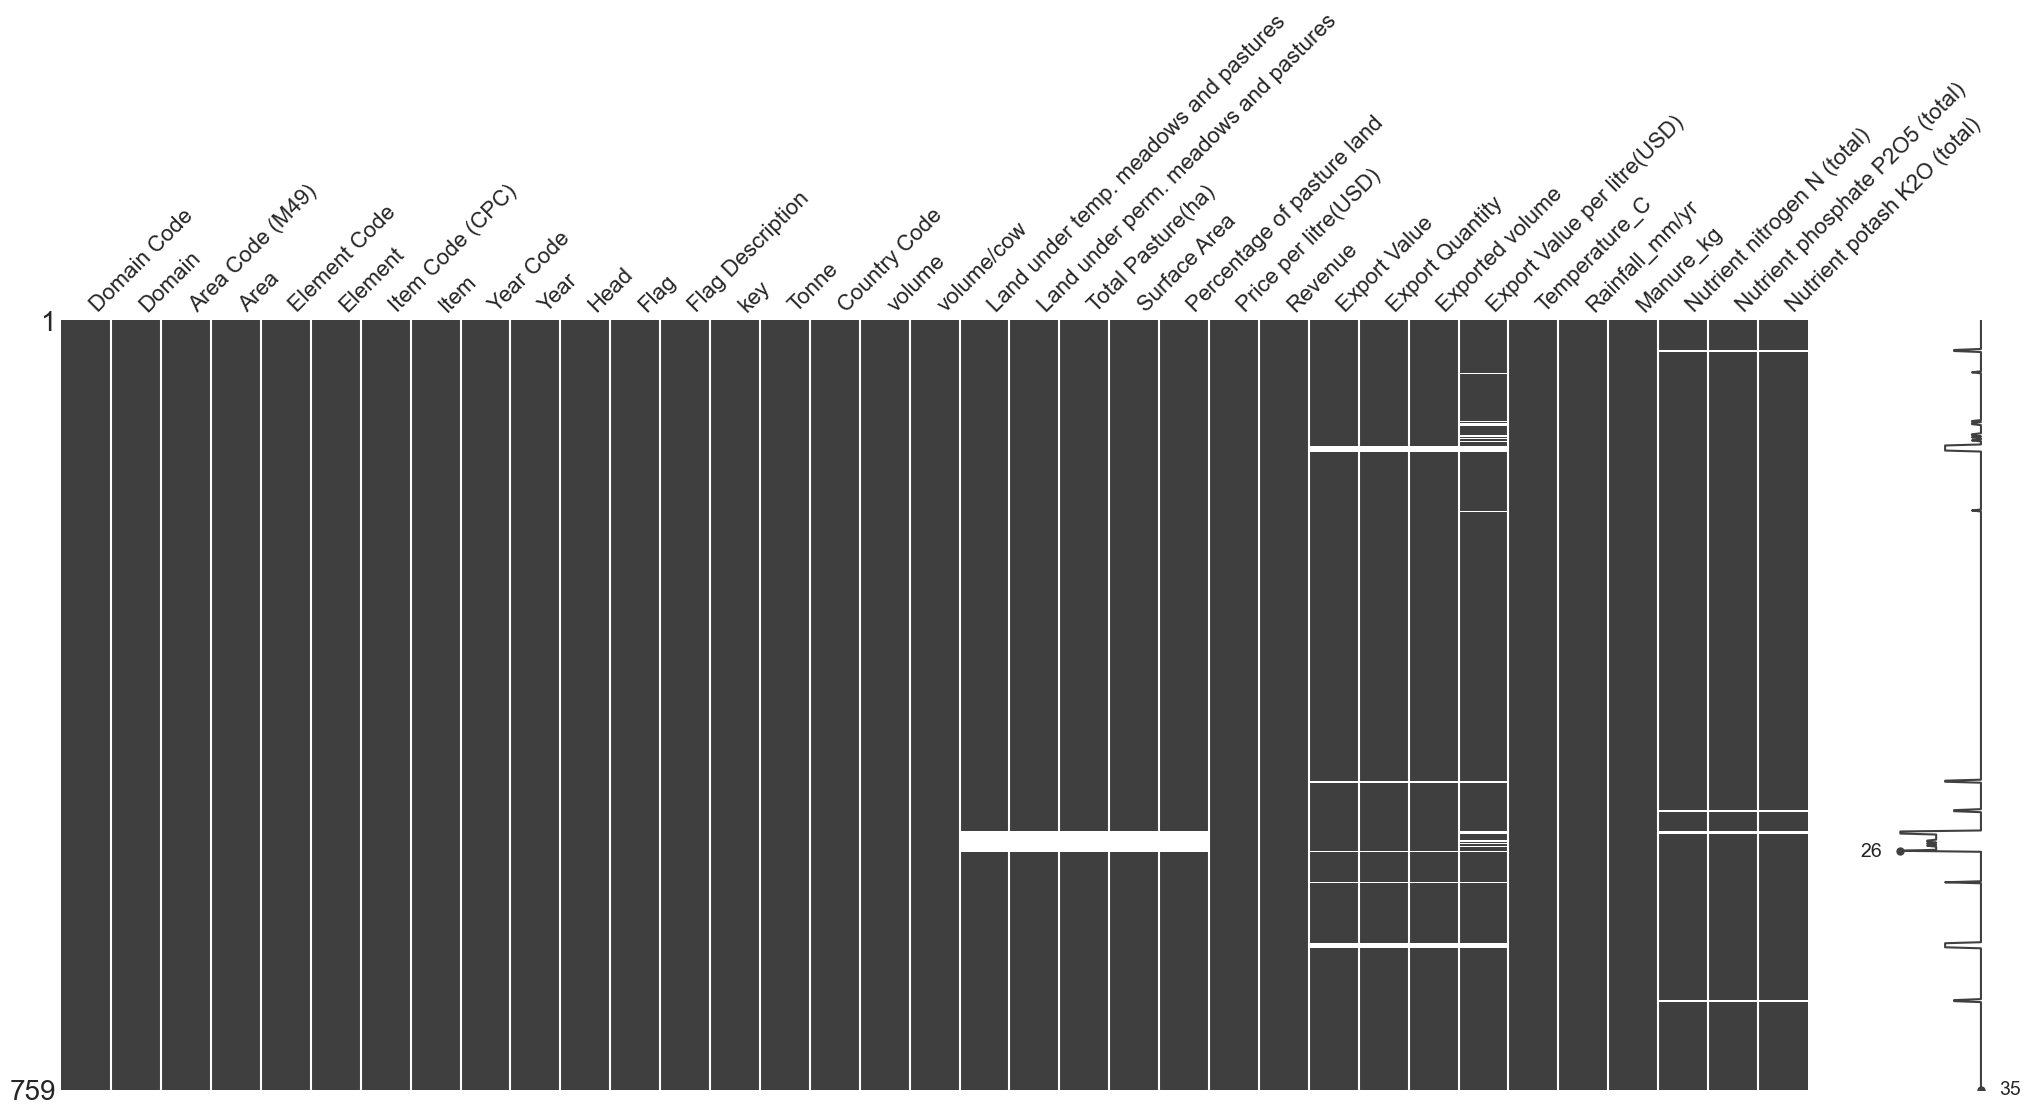

In [42]:
msno.matrix(milk_eu)

Theres a few things we will need to look at before moving forward here
* Missing values in the meadows and pastures data
* Misssing values in the Exports Data
* Missing values in the fertilizer data

I will address these in the following section & determine the best approach on a case by case basis.

# 2) Data cleaning stage

Lets kick things off by building a function that will loop over many imputation techniques and will compare their results, spitting out the best one.

### a) First we will tackle the missing data in the meadows and pastures data. Since all the columns missing values related to this were calculated using the same origin, it is likely that the same solution could be applied to each column

<AxesSubplot:>

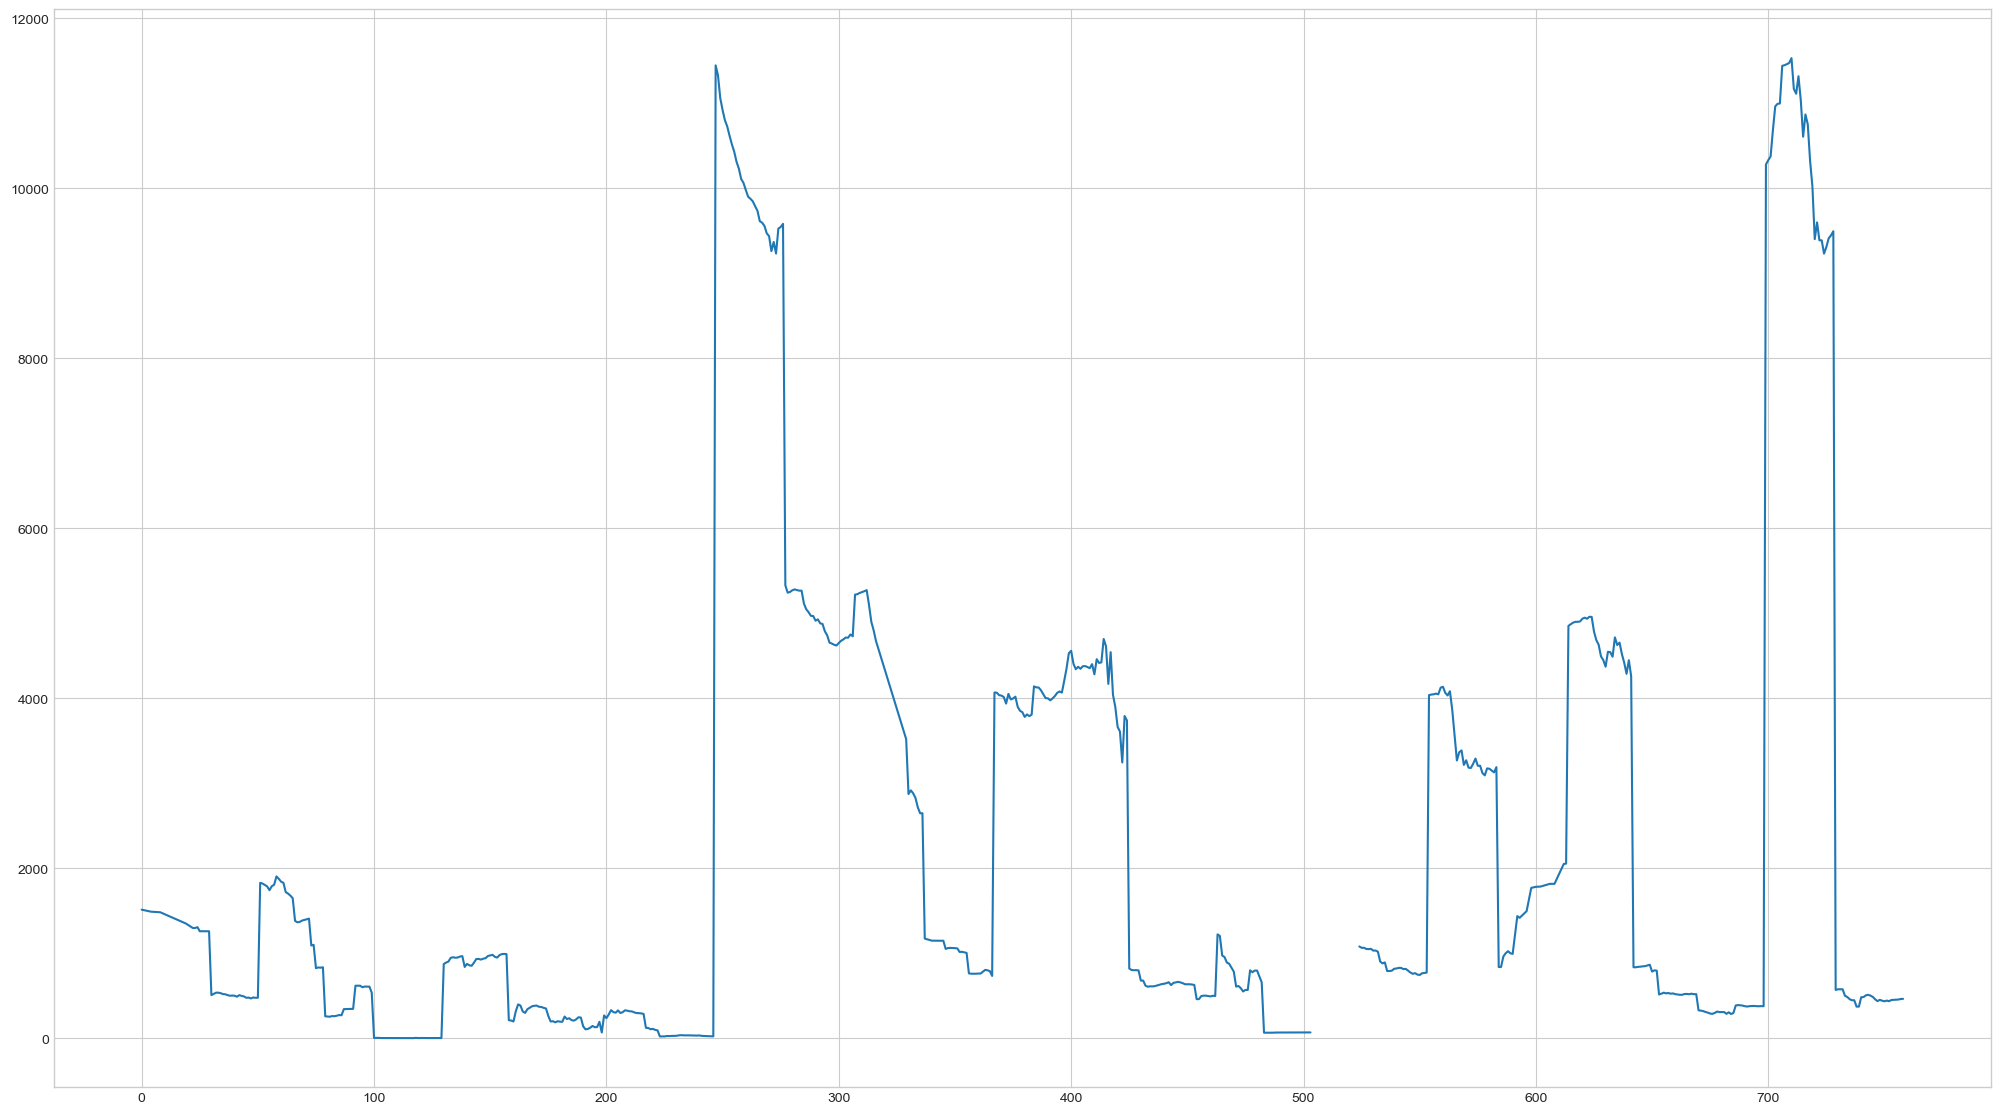

In [43]:
initial = milk_eu['Land under perm. meadows and pastures'].median()
milk_eu['Land under perm. meadows and pastures'].plot(kind = 'line')

925.17 955.1


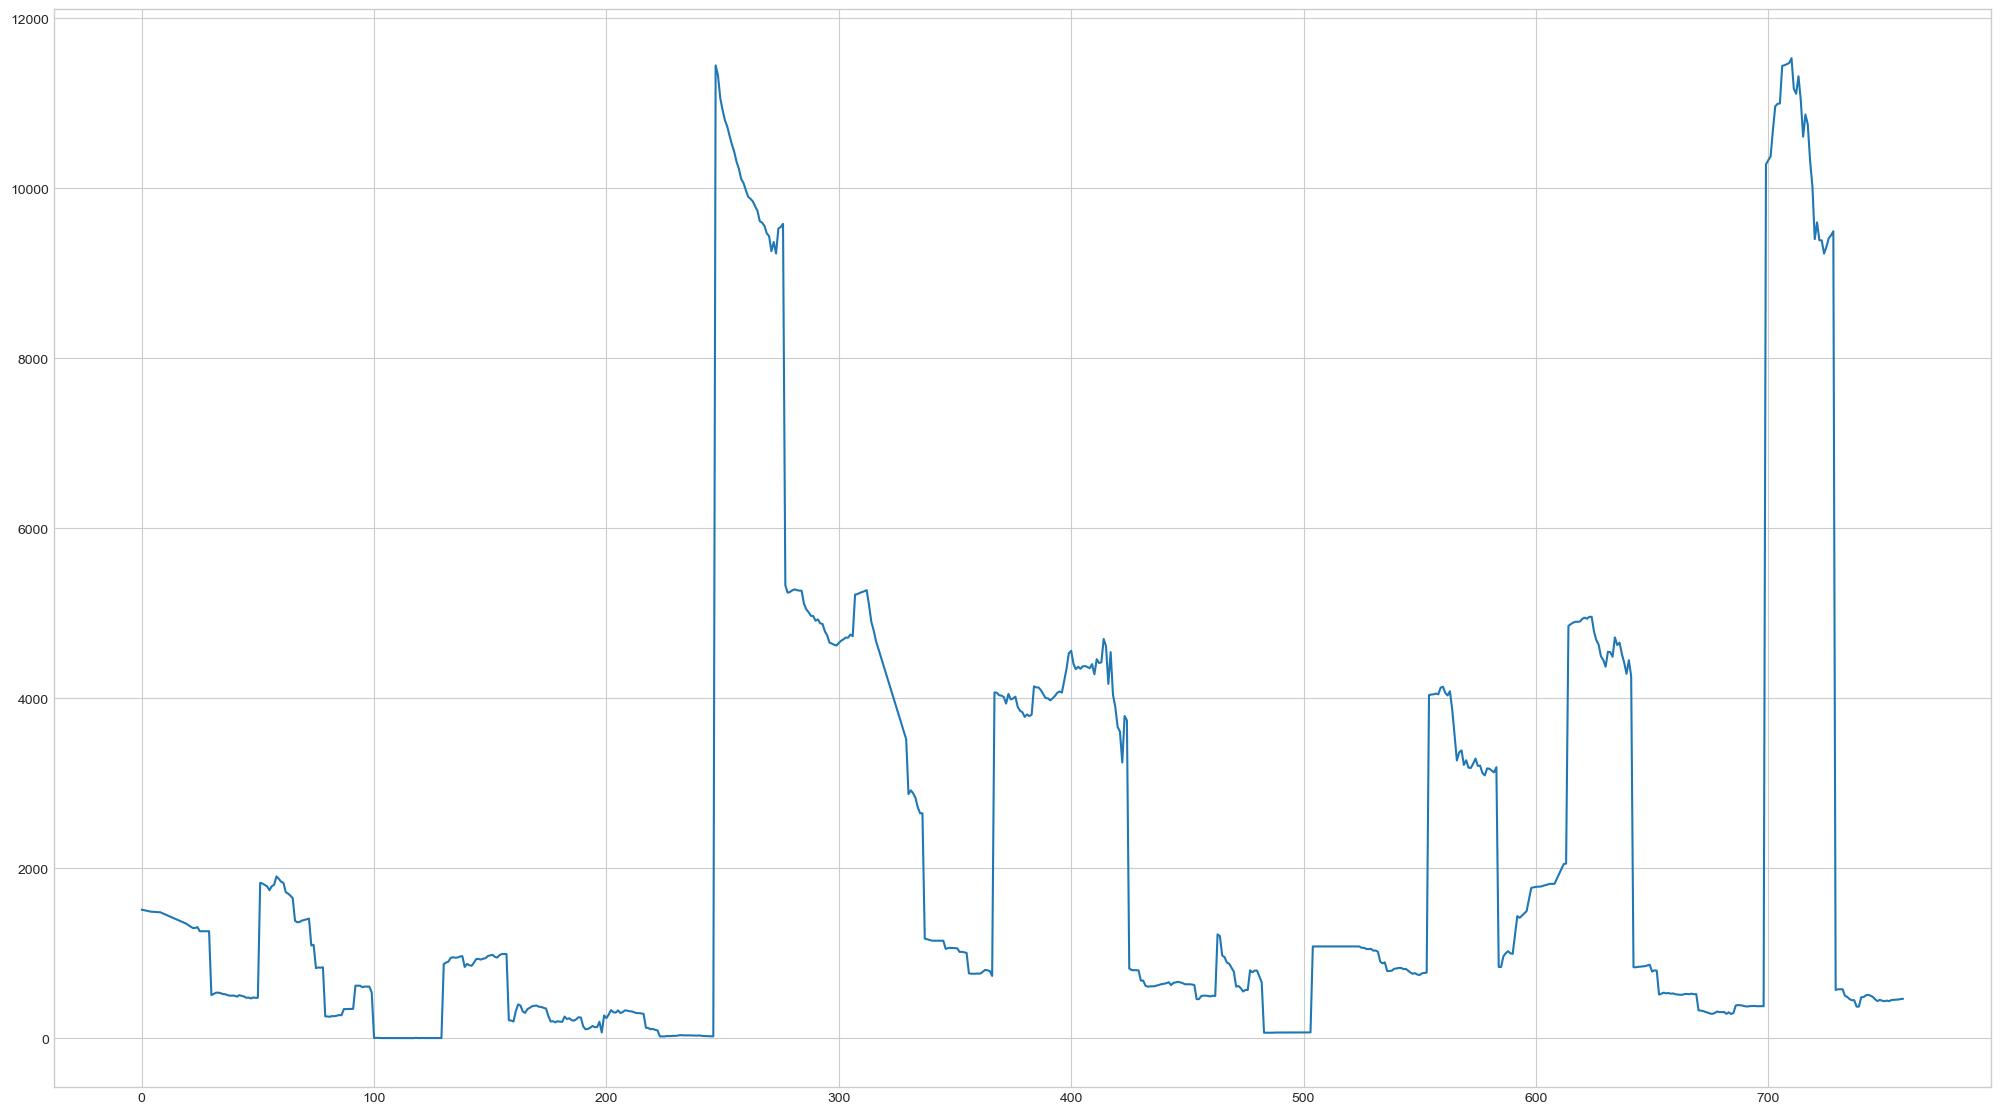

In [44]:
#fill na in this column with bfill
milk_eu['Land under perm. meadows and pastures'].fillna(method='bfill', inplace=True)
milk_eu['Land under perm. meadows and pastures'].plot(kind = 'line')
final = milk_eu['Land under perm. meadows and pastures'].median()
print(initial, final)